In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import warnings

In [2]:
train = pd.read_csv('C:\\Users\\guilh_000\Documents\\tweetsclassify\\train.csv', encoding='latin-1')

print(train.shape)

(99989, 3)


In [3]:
trainone = train[train['Sentiment']==1].head(12125)
#trainone.head(10)
train = train.drop(train.index[trainone.index])
train['Sentiment'].value_counts()

1    44332
0    43532
Name: Sentiment, dtype: int64

In [4]:
from textblob import TextBlob
def lemmatize_with_postag(sentence):
    sent = TextBlob(sentence)
    tag_dict = {"J":'a',"N":'n',"V":'v',"R":'r'}
    words_and_tags = [(w, tag_dict.get(pos[0],'n'))for w, pos in sent.tags]
    lemmatized_list = [wd.lemmatize(tag)for wd, tag in words_and_tags]
    return " ".join(lemmatized_list)

import string
import nltk
from nltk.corpus import stopwords
import re
def normalizer(tweet):
    punct = list(string.punctuation)
    stop_words = stopwords.words('english')
    additional_stop_words = ['RT','rt','via','...','http','twitpic','tinyurl','www', 'amp']
    stopword_list = punct + stop_words + additional_stop_words
    
    tweet = re.sub("(@[A-Za-z0-9]+)|(#[A-Za-z0-9]+)", " ", tweet)
    tweet_ = re.sub("(\w+:\/\/\S+)", " ", tweet)
    tweet__ = re.sub("[^a-zA-Z]", " ", tweet_)
    lemmatized = lemmatize_with_postag(tweet__)
    tokens = nltk.word_tokenize(lemmatized)[2:]
    lower_case = [l.lower() for l in tokens]
    filtered_result = list(filter(lambda l: l not in stopword_list, lower_case))
    return filtered_result

In [5]:
train['normalized'] = train.SentimentText.apply(normalizer)
train['normal'] = [' '.join(map(str, l)) for l in train['normalized']]

In [6]:
train['normal'].replace('', np.nan, inplace=True)
train.dropna(subset=['normal'], inplace=True)
#train.tail(20)
train['Sentiment'].value_counts()

0    41414
1    40860
Name: Sentiment, dtype: int64

In [7]:
from scipy.sparse import hstack
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer  

count_vectorizer = CountVectorizer(ngram_range=(1,2))
vectorized_data =count_vectorizer.fit_transform(train['normal'])

#tfidfconverter = TfidfTransformer()  
#tfid_data = tfidfconverter.fit_transform(vectorized_data)

#indexed_data =hstack((np.array(range(0,tfid_data.shape[0]))[:,None],tfid_data))

indexed_data =hstack((np.array(range(0,vectorized_data.shape[0]))[:,None],vectorized_data))

In [8]:
targets = train.iloc[:, 1]

from sklearn.model_selection import train_test_split 
data_train, data_test, targets_train, targets_test =train_test_split(indexed_data, targets, test_size=0.3,random_state=0)
data_train_index = data_train[:,0]
data_train = data_train[:,1:]
data_test_index = data_test[:,0]
data_test = data_test[:,1:]

In [9]:
###########################################################################################################
from sklearn import svm
clf = svm.SVC(C= 0.1, kernel='linear', gamma=1)
clf.fit(data_train, targets_train)

SVC(C=0.1, gamma=1, kernel='linear')

In [10]:
from sklearn.metrics import accuracy_score, confusion_matrix, precision_recall_fscore_support, classification_report

targets_pred = clf.predict(data_test)

print(confusion_matrix(targets_test, targets_pred))
print(classification_report(targets_test,targets_pred))
print(accuracy_score(targets_test, targets_pred))

[[7642 4778]
 [2587 9676]]
              precision    recall  f1-score   support

           0       0.75      0.62      0.67     12420
           1       0.67      0.79      0.72     12263

    accuracy                           0.70     24683
   macro avg       0.71      0.70      0.70     24683
weighted avg       0.71      0.70      0.70     24683

0.7016164971842969


In [61]:
tweet_test = ['I''m very happy today']
x = count_vectorizer.transform(tweet_test)
if(clf.predict(x)==1):
    print('Positive')
else:
    print('Negative')

Positive


In [24]:
###########################################################################################################
from sklearn import svm
sc = svm.SVC(C= 10, kernel='linear', gamma=1)
sc.fit(data_train, targets_train)

SVC(C=10, gamma=1, kernel='linear')

In [25]:
from sklearn.metrics import accuracy_score, confusion_matrix, precision_recall_fscore_support, classification_report

y_pred = sc.predict(data_test)

print(confusion_matrix(targets_test, y_pred))
print(classification_report(targets_test,y_pred))
print(accuracy_score(targets_test, y_pred))

[[8033 4387]
 [3740 8523]]
              precision    recall  f1-score   support

           0       0.68      0.65      0.66     12420
           1       0.66      0.70      0.68     12263

    accuracy                           0.67     24683
   macro avg       0.67      0.67      0.67     24683
weighted avg       0.67      0.67      0.67     24683

0.6707450471984767


In [29]:
tweettotest = ['corona beer was the worst beer I''ve ever tasted']
t = count_vectorizer.transform(tweettotest)
if(sc.predict(t)==1):
    print('Positive')
else:
    print('Negative')

Negative


# data visualization

In [33]:
isnegative = train[train.Sentiment == 0]
print(isnegative.shape)

(41414, 5)


In [34]:
allnegative = isnegative['normal']
allnegative.head()

0                                       sad apl friend
1                                     new moon trailer
3    sooo im gunna cry dentist since suposed get cr...
4                                          mi bf cheat
5                                           worry much
Name: normal, dtype: object

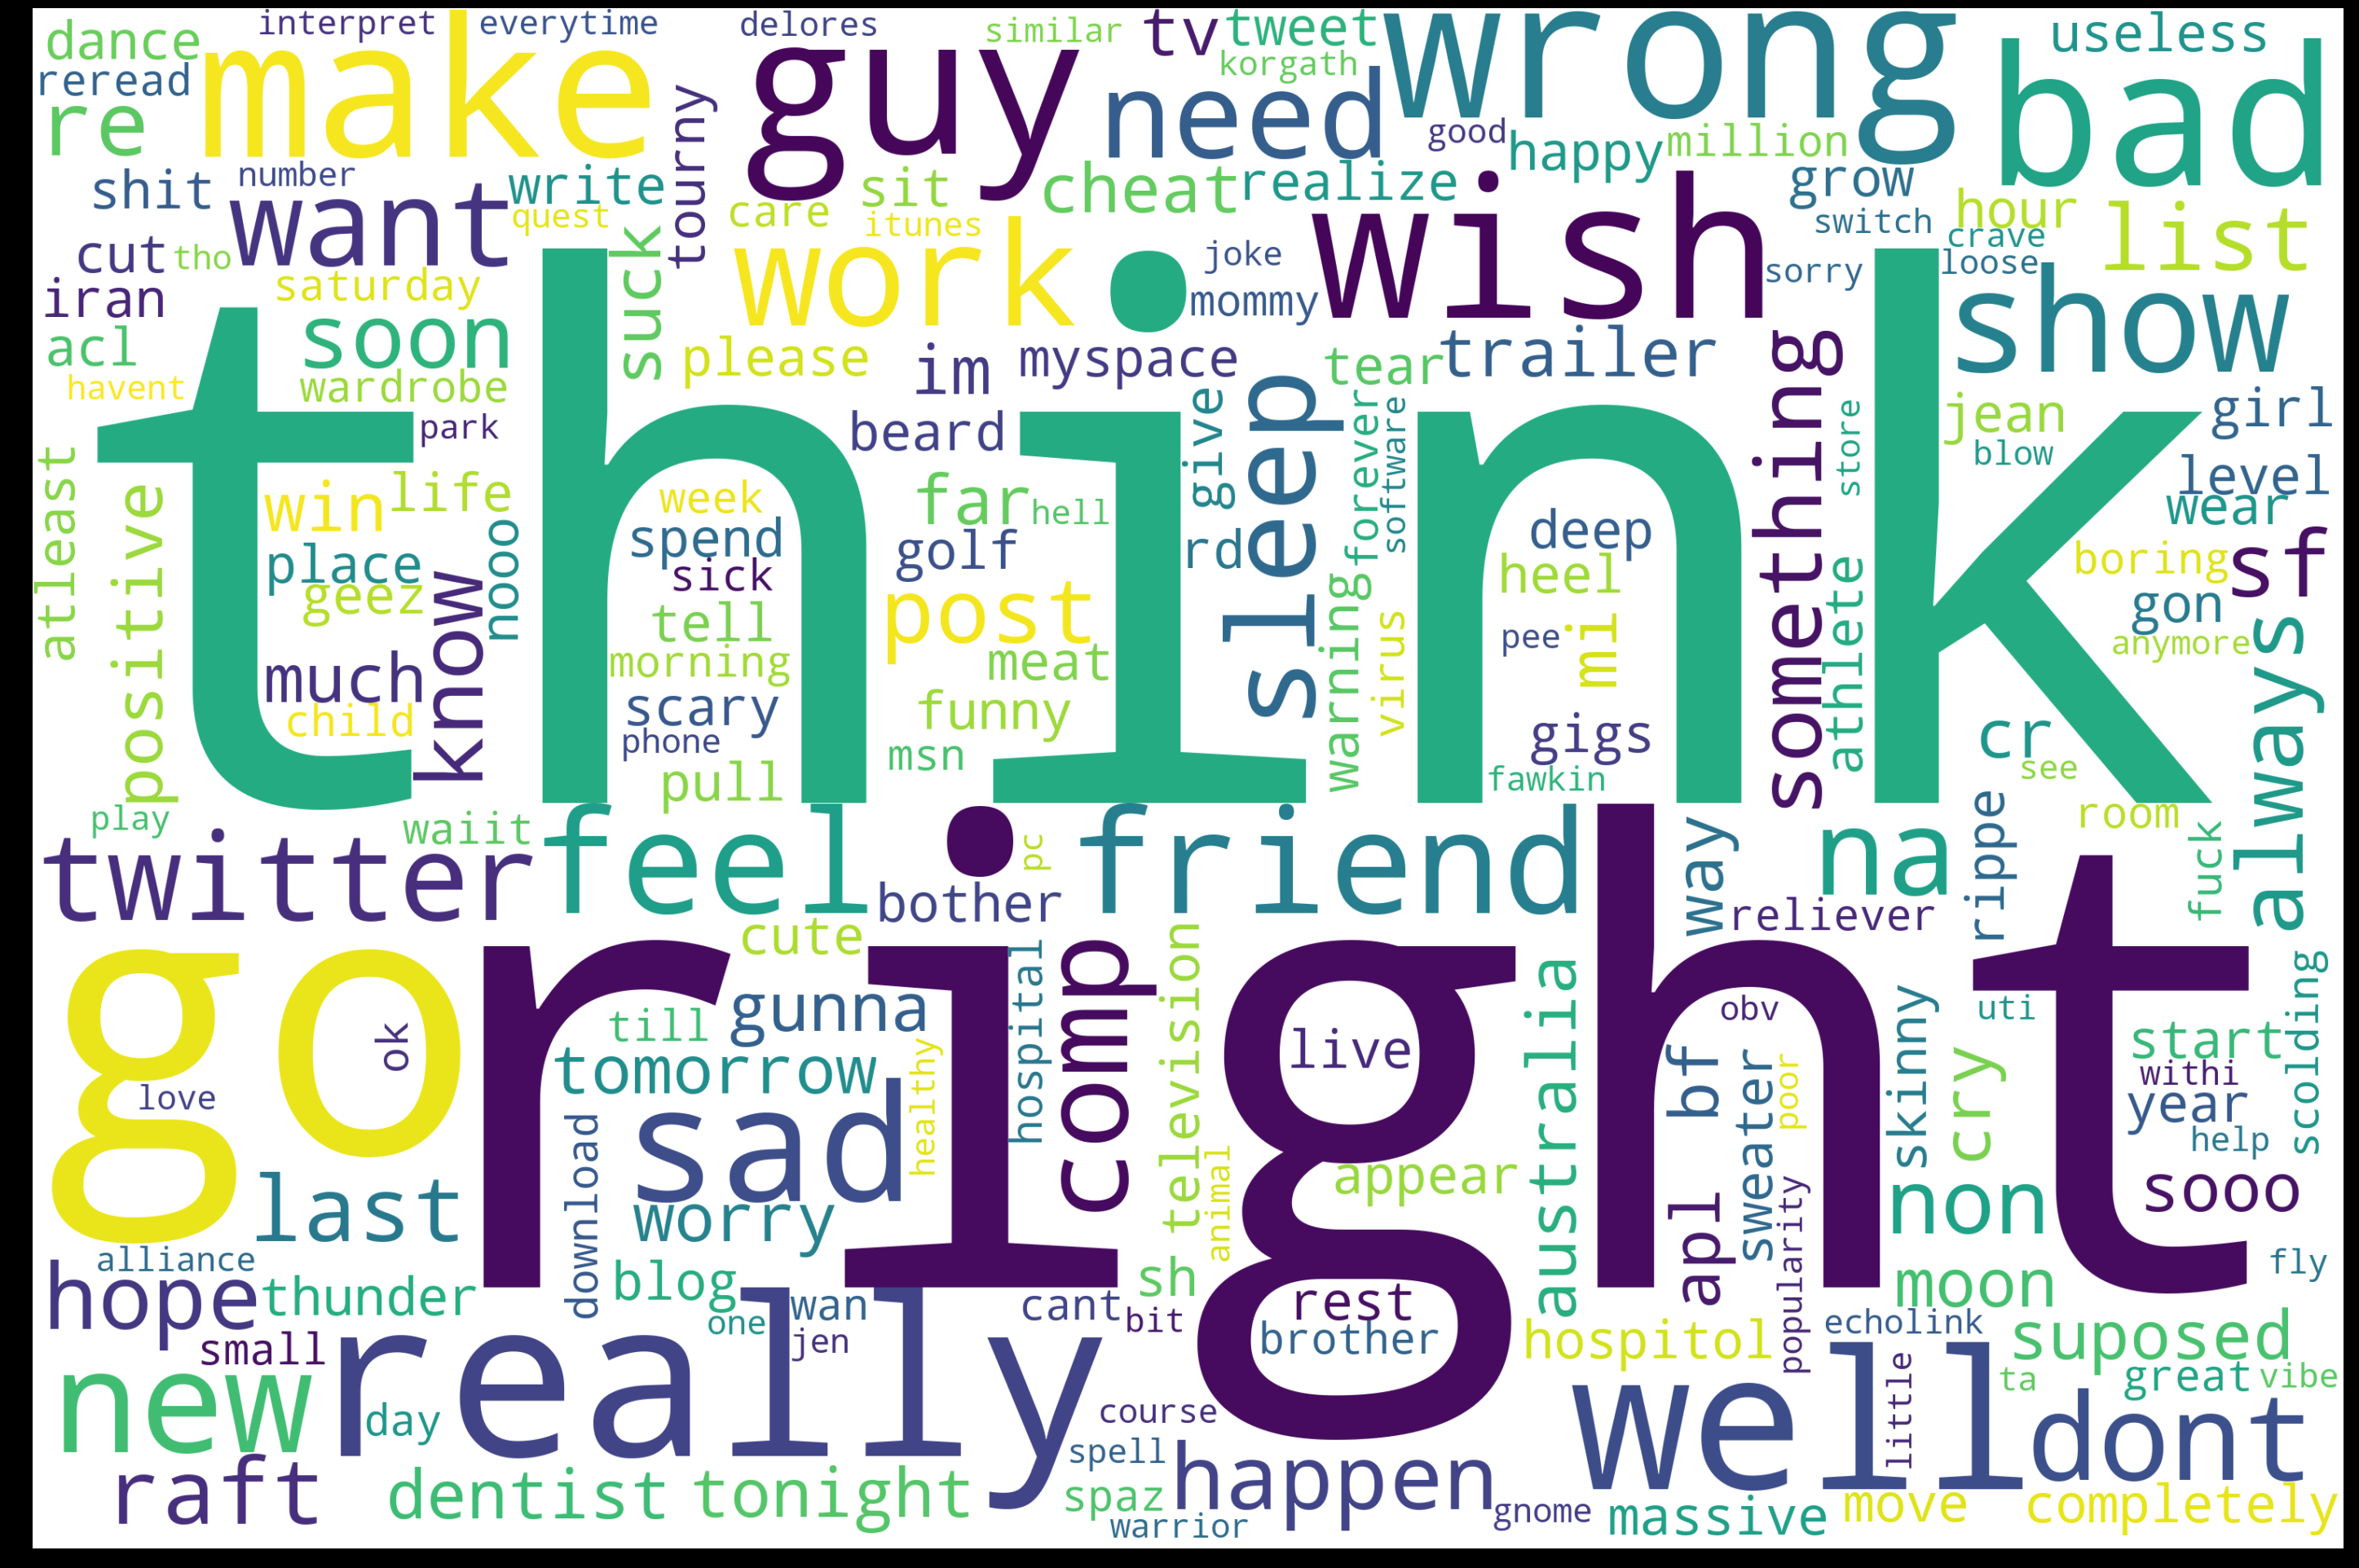

In [37]:
#build negativr wordcloud
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.cm as cm

text = isnegative.normal
wordcloud = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'white',
    stopwords = STOPWORDS).generate(str(text))
fig = plt.figure(
    figsize = (40, 30),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

In [38]:
ispositive = train[train.Sentiment == 1]
print(ispositive.shape)

(40860, 5)


In [39]:
allpositive = ispositive['normal']
allpositive.head()

24908      speaker course must pop blog post one interest
24910    tease people like u know probably drool ur video
24915                   sound awesome spread word set dvr
24919                                            car loan
24920                         many time enter online comp
Name: normal, dtype: object

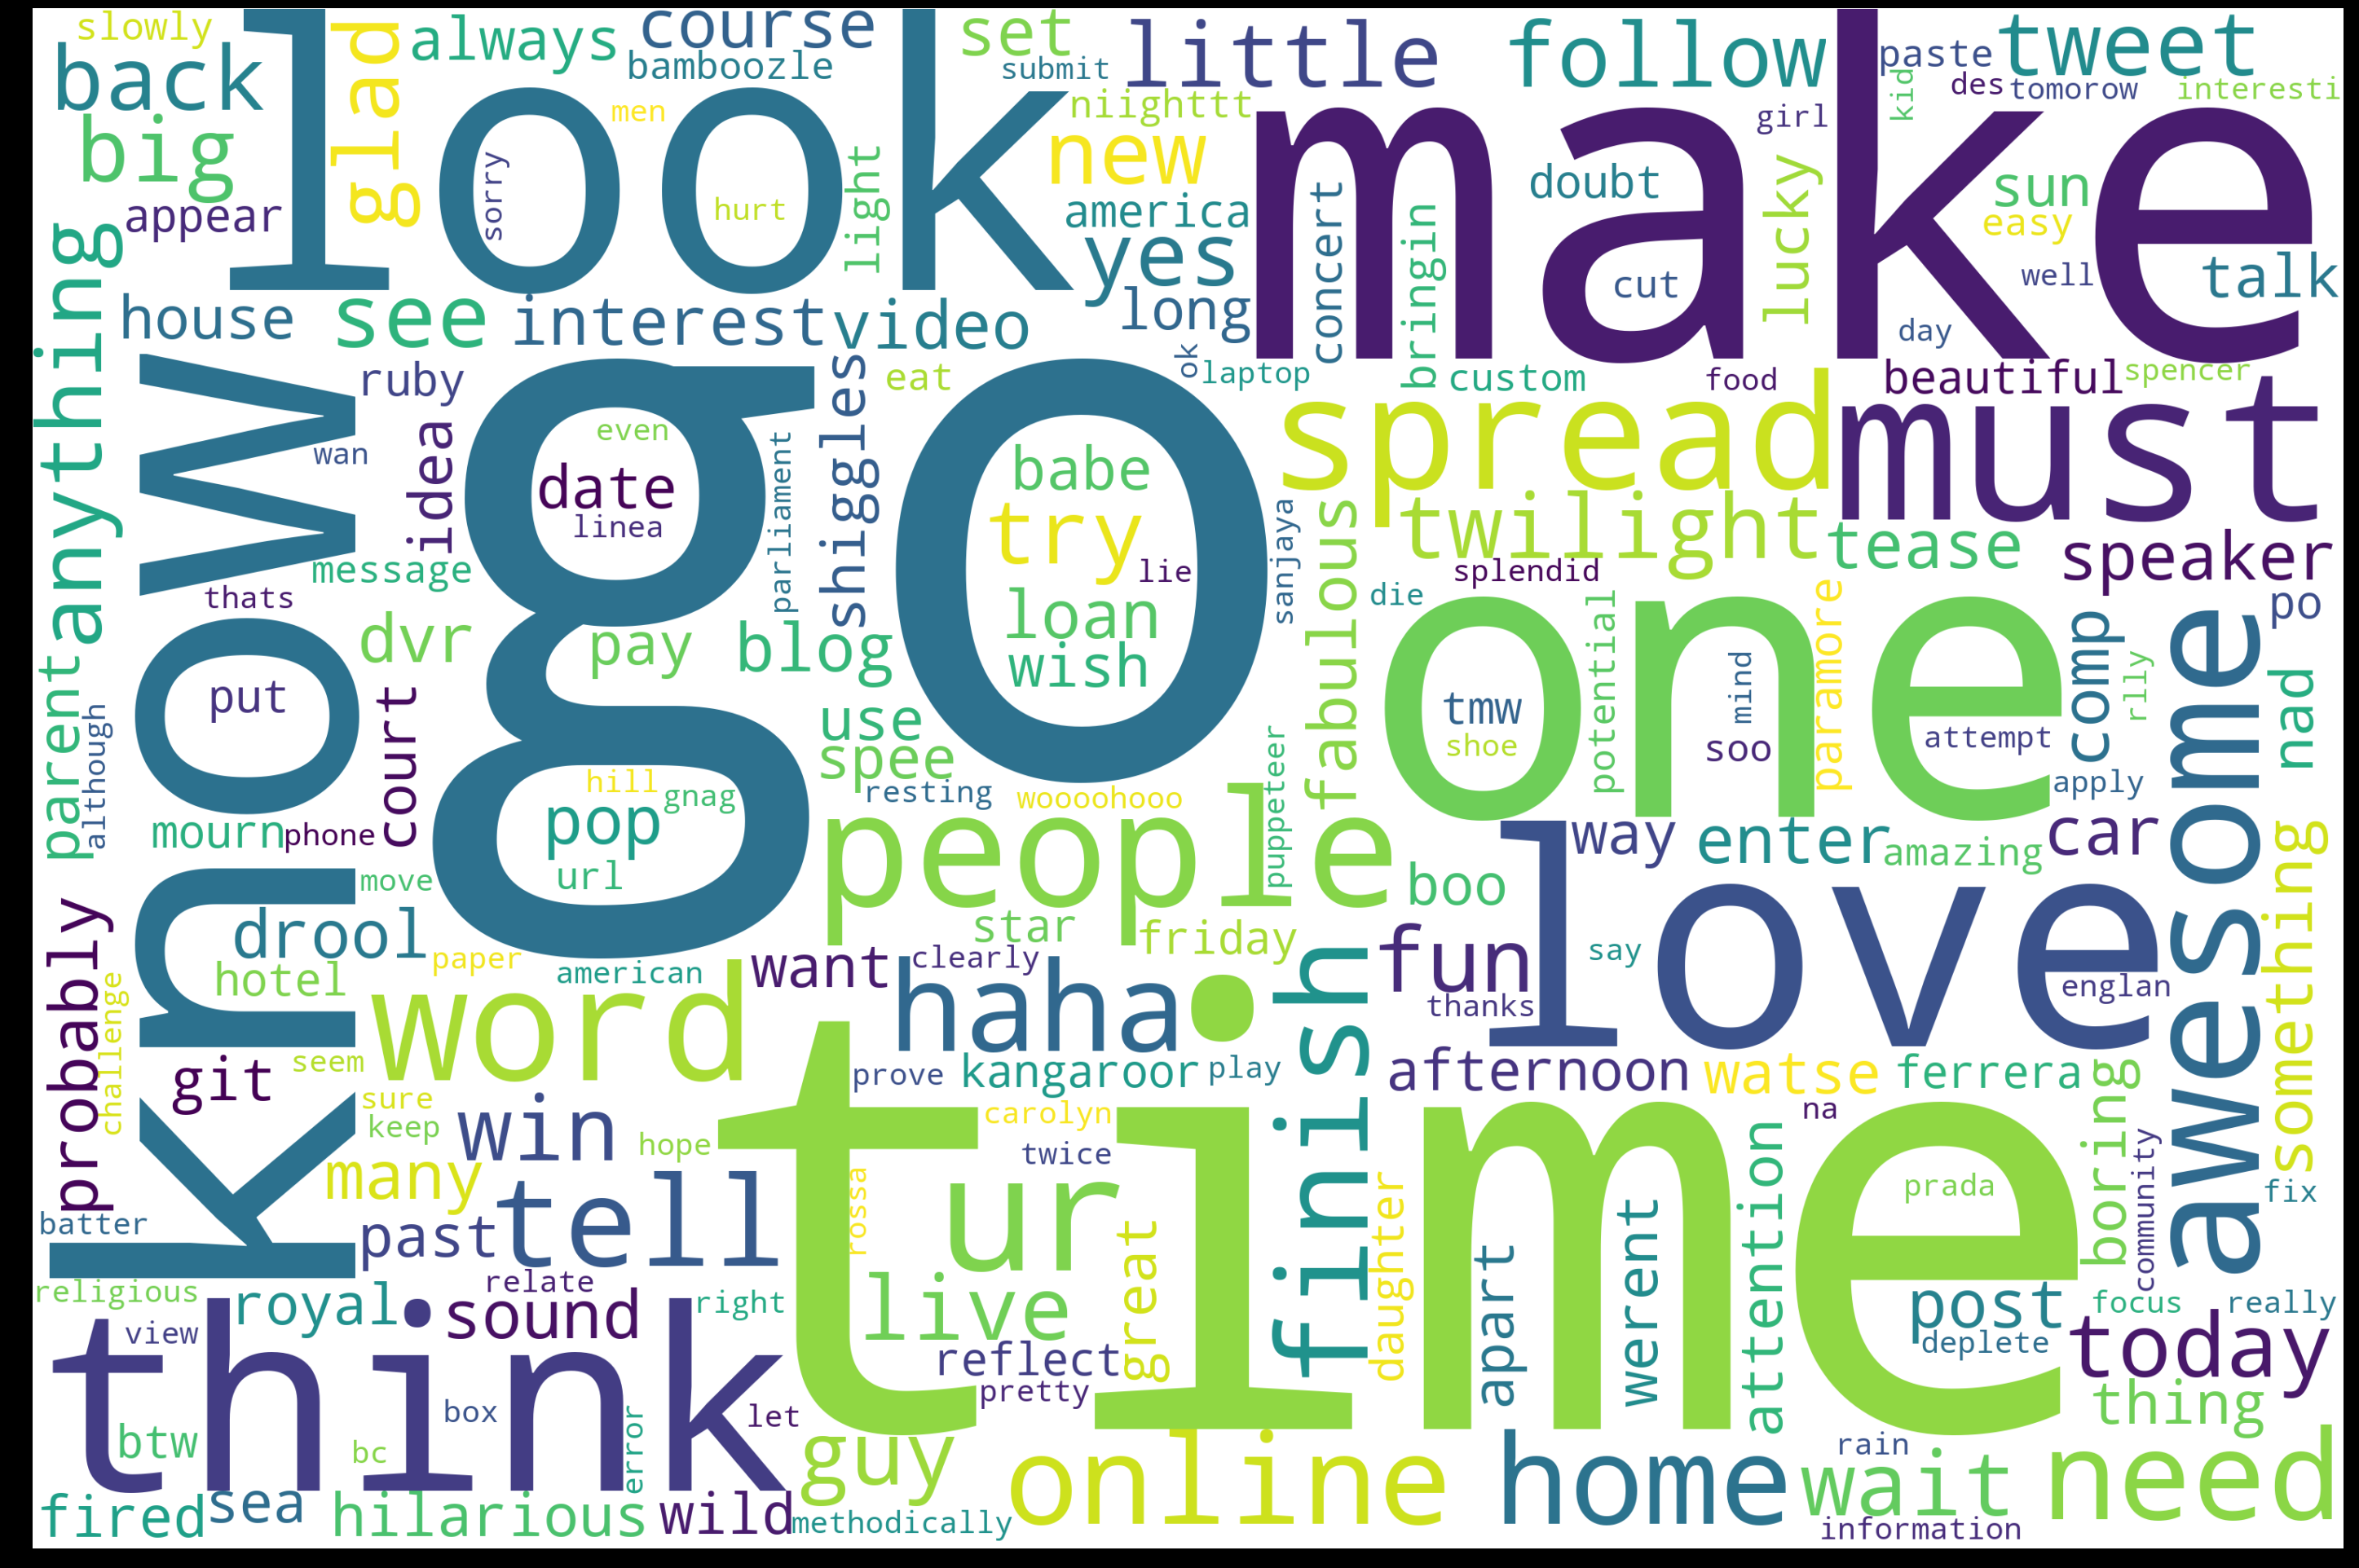

In [40]:
#build positive wordcloud
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.cm as cm

text = ispositive.normal
wordcloud = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'white',
    stopwords = STOPWORDS).generate(str(text))
fig = plt.figure(
    figsize = (40, 30),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()